In [1]:
import os
import time
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import Audio
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# audio path
dataset_path = '/kaggle/input/common-language/CommonLanguage/common_voice_kpd'

### Fungsi visualized_audio, ektraksi fitur, trim_audio, load_data

In [4]:
# Function to visualize audio data in subplots
def visualize_audio(audio_data, sample_rate):
    try:
        fig, axs = plt.subplots(5, 1, figsize=(12, 15))
        
        # Plot waveplot
        librosa.display.waveshow(audio_data, sr=sample_rate, ax=axs[0])
        axs[0].set(title='Waveplot')
        
        # Plot mel-spectrogram
        mel_spect = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        img = librosa.display.specshow(mel_spect_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=axs[1])
        fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
        axs[1].set(title='Mel-Spectrogram')
        
        # Plot chroma feature
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        img = librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma', ax=axs[2])
        fig.colorbar(img, ax=axs[2])
        axs[2].set(title='Chroma Feature')
        
        # Plot spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        img = librosa.display.specshow(spectral_contrast, sr=sample_rate, x_axis='time', ax=axs[3])
        fig.colorbar(img, ax=axs[3])
        axs[3].set(title='Spectral Contrast')
        
        # Plot tonnetz feature
        harmonic = librosa.effects.harmonic(audio_data)
        tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sample_rate)
        img = librosa.display.specshow(tonnetz, sr=sample_rate, x_axis='time', ax=axs[4])
        fig.colorbar(img, ax=axs[4])
        axs[4].set(title='Tonnetz')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error encountered while parsing audio data. Error message: {str(e)}")

In [7]:
# Function to trim silence from audio data
def trim_silence(audio_data, sample_rate):
    trimmed_audio, _ = librosa.effects.trim(audio_data, top_db=20, hop_length=16)
    return trimmed_audio

### Load dan trim audio file

In [12]:
# # Function to extract features from an audio file
# def extract_features(audio_data, sample_rate):
#     features = {}
#     stft = np.abs(librosa.stft(audio_data))
    
#     features['chroma_stft_mean'] = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
#     features['chroma_stft_var'] = np.var(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
#     features['rms_mean'] = np.mean(librosa.feature.rms(y=audio_data))
#     features['rms_var'] = np.var(librosa.feature.rms(y=audio_data))
#     features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate))
#     features['spectral_centroid_var'] = np.var(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate))
#     features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate))
#     features['spectral_bandwidth_var'] = np.var(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate))
    
#     mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
#     for i in range(1, 21):
#         features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
#         features[f'mfcc{i}_var'] = np.var(mfccs[i-1])
    
#     return features

In [13]:
def extract_features(audio_data, sample_rate):
    features = {}
    stft = np.abs(librosa.stft(audio_data))
    
    features['chroma_stft_mean'] = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    features['chroma_stft_var'] = np.var(librosa.feature.chroma_stft(S=stft, sr=sample_rate))
    features['rms_mean'] = np.mean(librosa.feature.rms(y=audio_data))
    features['rms_var'] = np.var(librosa.feature.rms(y=audio_data))
    features['spectral_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate))
    features['spectral_centroid_var'] = np.var(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate))
    features['spectral_bandwidth_mean'] = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate))
    features['spectral_bandwidth_var'] = np.var(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate))
    
    # Additional features
    features['zero_crossing_rate_mean'] = np.mean(librosa.feature.zero_crossing_rate(y=audio_data))
    features['zero_crossing_rate_var'] = np.var(librosa.feature.zero_crossing_rate(y=audio_data))
    features['spectral_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate))
    features['spectral_rolloff_var'] = np.var(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate))
    features['spectral_flatness_mean'] = np.mean(librosa.feature.spectral_flatness(y=audio_data))
    features['spectral_flatness_var'] = np.var(librosa.feature.spectral_flatness(y=audio_data))
    spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
    for i in range(spectral_contrast.shape[0]):
        features[f'spectral_contrast_{i}_mean'] = np.mean(spectral_contrast[i])
        features[f'spectral_contrast_{i}_var'] = np.var(spectral_contrast[i])
    
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
        features[f'mfcc{i}_var'] = np.var(mfccs[i-1])
    
    return features

In [14]:
# Function to load, trim and extract features from audio files with multithreading
def load_trim_extract_multithreaded(dataset_path):
    audio_data_list = []
    labels = []

    def load_and_trim_and_extract(file_path, label):
        try:
            audio_data, sample_rate = librosa.load(file_path, sr=None)
            trimmed_audio = trim_silence(audio_data, sample_rate)
            features = extract_features(trimmed_audio, sample_rate)
            features['label'] = label
            return features
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            return None

    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
        futures = []
        start_time = time.time()
        for language_folder in os.listdir(dataset_path):
            language_folder_path = os.path.join(dataset_path, language_folder)
            if os.path.isdir(language_folder_path):
                train_path = os.path.join(language_folder_path, 'train')
                test_path = os.path.join(language_folder_path, 'test')
                val_path = os.path.join(language_folder_path, 'dev')
                
                # Process files in train and test folders
                for path in [train_path, test_path, val_path]:
                    if os.path.isdir(path):
                        for subfolder in os.listdir(path):
                            subfolder_path = os.path.join(path, subfolder)
                            if os.path.isdir(subfolder_path):
                                for file in os.listdir(subfolder_path):
                                    file_path = os.path.join(subfolder_path, file)
                                    if file_path.endswith(".wav"):
                                        futures.append(executor.submit(load_and_trim_and_extract, file_path, language_folder))
        
        # Retrieve results from futures
        for future in futures:
            result = future.result()
            if result is not None:
                audio_data_list.append(result)
        
        end_time = time.time()
        print(f"Total time taken to load, trim, and extract features: {end_time - start_time:.2f} seconds")
    
    return audio_data_list

In [15]:
# Load, trim and extract features
audio_data_list = load_trim_extract_multithreaded(dataset_path)

Total time taken to load, trim, and extract features: 6596.57 seconds


In [16]:
# Create DataFrame
df = pd.DataFrame(audio_data_list)
df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,zero_crossing_rate_mean,zero_crossing_rate_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.534530,0.075348,0.120575,0.002834,1559.968124,2.083944e+05,1440.110802,66386.921190,0.107277,0.001627,...,168.795914,-11.085475,86.241653,-2.697865,61.670761,3.051130,110.920776,1.472672,99.098747,Arabic
1,0.507677,0.079905,0.110412,0.002218,1904.013580,1.305704e+06,1501.468425,221158.212183,0.188337,0.025398,...,95.179199,-16.283134,145.953735,-0.147890,101.026527,-1.339790,103.979492,3.529274,154.537872,Arabic
2,0.469659,0.072708,0.240846,0.006827,1506.149079,9.470994e+05,1251.941323,307529.193351,0.140831,0.015887,...,68.422791,-3.390711,46.420986,-6.909777,41.503948,-3.293839,86.047256,4.027842,47.551010,Arabic
3,0.489790,0.070976,0.097279,0.003832,2198.464021,5.359105e+05,1631.691797,79742.483151,0.180233,0.006681,...,57.492928,-1.876819,51.329967,-1.253196,44.661720,-2.383170,100.462631,0.865081,70.779175,Arabic
4,0.492185,0.075696,0.098836,0.004254,1968.559027,9.535243e+05,1543.263084,240812.684106,0.178969,0.014712,...,226.456268,-6.663990,129.467499,-0.214508,100.800156,-5.297744,73.068802,4.425282,156.211426,Arabic


In [23]:
df['label'].value_counts()

label
Breton               1190
Swedish              1059
Hakha_Chin           1006
Chinese_Taiwan       1001
Latvian               985
Tatar                 928
Kabyle                922
Arabic                917
Indonesian            911
Slovenian             897
Dutch                 850
Romanian              849
Greek                 840
Interlingua           828
Turkish               824
Czech                 814
Tamil                 789
Kyrgyz                777
Persian               761
Maltese               759
Japanese              756
Portuguese            746
Chuvash               734
Polish                732
Ukranian              727
Welsh                 691
Frisian               691
Chinese_Hongkong      672
Romansh_Sursilvan     659
Dhivehi               654
Kinyarwanda           649
Esperanto             645
Basque                638
Georgian              630
Mangolian             628
French                622
German                611
Catalan               610
Chines

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34047 entries, 0 to 34046
Data columns (total 69 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   chroma_stft_mean          34047 non-null  float32
 1   chroma_stft_var           34047 non-null  float32
 2   rms_mean                  34047 non-null  float32
 3   rms_var                   34047 non-null  float32
 4   spectral_centroid_mean    34047 non-null  float64
 5   spectral_centroid_var     34047 non-null  float64
 6   spectral_bandwidth_mean   34047 non-null  float64
 7   spectral_bandwidth_var    34047 non-null  float64
 8   zero_crossing_rate_mean   34047 non-null  float64
 9   zero_crossing_rate_var    34047 non-null  float64
 10  spectral_rolloff_mean     34047 non-null  float64
 11  spectral_rolloff_var      34047 non-null  float64
 12  spectral_flatness_mean    34047 non-null  float32
 13  spectral_flatness_var     34047 non-null  float32
 14  spectr

In [18]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder with your actual labels
label_encoder.fit(df['label'])

# Transform actual labels to numeric labels
df['numeric_labels'] = label_encoder.transform(df['label'])

In [19]:
# Menghitung jumlah unique labels
unique_labels = np.unique(df['numeric_labels'])
num_unique_labels = len(unique_labels)

print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {num_unique_labels}")

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
Number of unique labels: 45


In [20]:
X = df.drop(columns=['label','numeric_labels'])
y = df['numeric_labels']

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
np.random.seed(42)

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Latih model pada data latih
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Prediksi dengan data uji
y_pred = rf_model.predict(X_test)

# Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model Random Forest: {accuracy:.2f}")

# Laporan klasifikasi
print(classification_report(y_test, y_pred))

Akurasi model Random Forest: 0.38
              precision    recall  f1-score   support

           0       0.19      0.31      0.24       173
           1       0.17      0.12      0.14       139
           2       0.39      0.63      0.49       242
           3       0.17      0.13      0.15       130
           4       0.16      0.07      0.10       126
           5       0.34      0.40      0.37       126
           6       0.13      0.14      0.13       189
           7       0.42      0.79      0.55       140
           8       0.38      0.36      0.37       197
           9       0.51      0.59      0.55       135
          10       0.14      0.20      0.16       147
          11       0.06      0.02      0.03       124
          12       0.16      0.10      0.12       118
          13       0.46      0.26      0.34       122
          14       0.15      0.07      0.09       117
          15       0.27      0.34      0.30       125
          16       0.58      0.89      0.70    

In [33]:
import xgboost as xgb

#Inisialisasi model XGBoost
xgbmodel = xgb.XGBClassifier(
    objective='multi:softmax',  # untuk klasifikasi multi-kelas
    num_class=len(np.unique(y_train))  # jumlah kelas
#     max_depth=6,  # kedalaman maksimum dari setiap pohon
#     n_estimators=100  # jumlah pohon
)

In [34]:
# Melatih model
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=45,
              num_parallel_tree=None, ...)

In [35]:
from sklearn.metrics import accuracy_score, classification_report

# Prediksi dengan data uji
y_pred = xgbmodel.predict(X_test)

# Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model Random Forest: {accuracy:.2f}")

# Laporan klasifikasi
print(classification_report(y_test, y_pred))

Akurasi model Random Forest: 0.40
              precision    recall  f1-score   support

           0       0.19      0.25      0.22       173
           1       0.21      0.24      0.22       139
           2       0.57      0.64      0.60       242
           3       0.19      0.15      0.17       130
           4       0.21      0.14      0.17       126
           5       0.41      0.37      0.38       126
           6       0.20      0.23      0.21       189
           7       0.60      0.70      0.65       140
           8       0.42      0.33      0.37       197
           9       0.61      0.56      0.58       135
          10       0.15      0.23      0.19       147
          11       0.13      0.10      0.11       124
          12       0.21      0.16      0.18       118
          13       0.45      0.28      0.34       122
          14       0.16      0.14      0.15       117
          15       0.34      0.38      0.36       125
          16       0.71      0.83      0.77    

In [37]:
from sklearn.ensemble import GradientBoostingClassifier

#Inisialisasi model XGBoost
gbmodel = GradientBoostingClassifier(random_state=42)
#gbmodel = GradientBoostingClassifier(n_estimators=50, max_depth=6, random_state=42)
gbmodel.fit(X_train,y_train)

GradientBoostingClassifier(random_state=42)

In [38]:
from sklearn.metrics import accuracy_score, classification_report

# Prediksi dengan data uji
y_pred = gbmodel.predict(X_test)

# Evaluasi akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model Random Forest: {accuracy:.2f}")

# Laporan klasifikasi
print(classification_report(y_test, y_pred))

Akurasi model Random Forest: 0.30
              precision    recall  f1-score   support

           0       0.14      0.15      0.14       173
           1       0.21      0.16      0.18       139
           2       0.39      0.48      0.43       242
           3       0.16      0.13      0.14       130
           4       0.15      0.08      0.10       126
           5       0.34      0.37      0.35       126
           6       0.15      0.14      0.14       189
           7       0.36      0.53      0.43       140
           8       0.27      0.24      0.25       197
           9       0.47      0.44      0.45       135
          10       0.12      0.16      0.14       147
          11       0.13      0.06      0.09       124
          12       0.07      0.06      0.06       118
          13       0.23      0.20      0.22       122
          14       0.08      0.06      0.07       117
          15       0.23      0.30      0.26       125
          16       0.56      0.74      0.64    

### Contoh Visualisasi Audio

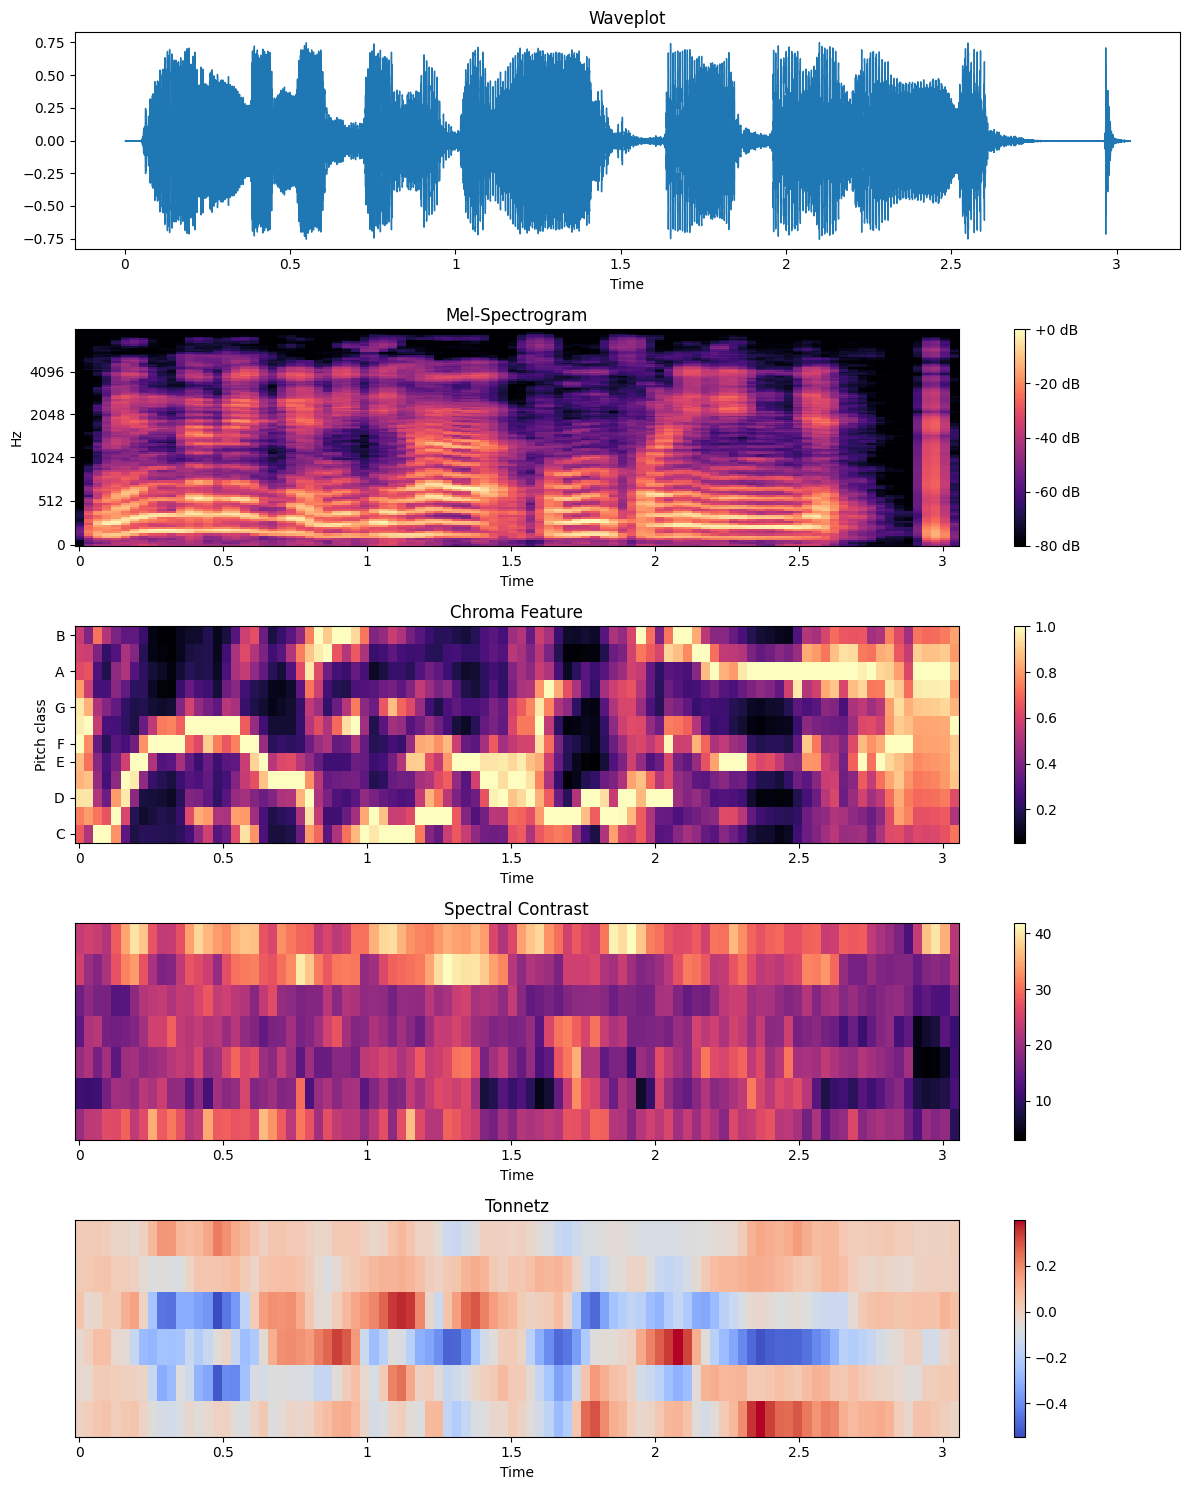

In [31]:
sample_audio, sample_rate = trimmed_audio_list[1000]
visualize_audio(sample_audio, sample_rate)

In [32]:
# Memainkan audio menggunakan IPython.display.Audio
Audio(data=sample_audio, rate=sample_rate)